In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
#Check pandas version to make sure 0.25.1 and the worksheet is working
pd.__version__

'0.25.1'

In [4]:
%matplotlib inline

**How to use this worksheet**

**1.Point Misty at something interesting**

    There needs to be different levels of depth or something interesting in the frame. 


**2.Get Depth Data**

    The data is pulled in using either Misty API Explorer or Postman. 
    GET http://<your Misty robots IP address>/api/cameras/depth

    The data should be in json format: 
    {
        "result": {
            "height": 240,
            "image": [ "NaN", ...],
            "width": 320
        },
        "status": "Success"
    }     
      
3. Save the data as a <yourfilename>.json file
    
4. Update the script below to reference your file 

4. Run each of the cells

later: Take a fisheye picture and compare


In [5]:
# Read in a json file

#depth = pd.read_json('../coderepo/<your file name here>.json')
data = pd.read_json('../coderepo/BB8_HW.json')

#Transpose the DataFrame to get the column labels to contain height width, and image
dataT = data.T

print(" The height and width should be (240, 320):", dataT['height'].result, dataT['width'].result);
dataT

 The height and width should be (240, 320): 240 320


,height,image,width
result,240,"[NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, ...",320
status,Success,Success,Success


In [87]:
#Next Extract the Image
sf = dataT['image'].result;

#Turn the result into a DataFrame
depth = pd.DataFrame(sf);

#Rename the volumn values
depth.rename(columns={0:'Values'}, inplace=True);

#Check to see the count of NaN values in the Image - Count all NaN's
NaN_cnt = (depth.Values == 'NaN').sum(); 

coverage = round(((76800-NaN_cnt)/76800)*100,2) #percent of non-NaN "good" values
print("Depth point coverage is: ", coverage, "%");


if coverage < 50: 
    print("Data not so good - you may not have valid data in all cells")    
    print("You may have problems running the rest of the cells")  
    

Depth point coverage is:  41.88 %
Data not so good - you may not have valid data in all cells
You may have problems running the rest of the cells


In [88]:
depth.describe()

,Values
count,76800
unique,4695
top,NaN
freq,44636


In [99]:
#Replace all of the NaN's with 0
# "fo" is just an intermediate holding variable
fo = depth.replace('NaN',0)

#Check to make sure there are no NaNs
numberNaN = (fo.Values == 'NaN').sum() 

#Reshape the array
data = np.array(fo).reshape((240,320))
data.shape

#Check to make sure all NaN's were replaced
print(" There are " + str(numberNaN) + " NaN's, and the array is " +str(data.shape) + " of type " + str(type(data)) )

 There are 0 NaN's, and the array is (240, 320) of type <class 'numpy.ndarray'>


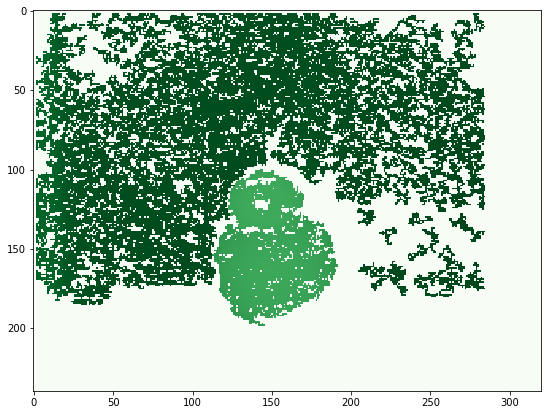

In [104]:
#Plot the figure with a couple of overlays

plt.rcParams['figure.figsize'] = [12, 7]
#plt.imshow(data, cmap=plt.get_cmap('gray'));
#plt.imshow(data, cmap=plt.get_cmap('gray'));
plt.imshow(data, cmap=plt.get_cmap('Greens'));

#Some other plot methods
#plt.rcParams['figure.figsize'] = [9, 7]
#plt.contour(data)
#plt.gca().invert_yaxis() #need to rotate or flip it so that 0 is at the top 

#plt.rcParams['figure.figsize'] = [9, 7]
#plt.pcolormesh(data);

In [60]:
#Create the column arrays for the sum results to be stored in
#There are 320 columns so create zero arrays of length 320

#Create Column Arrays for the entire picture
colDepthSum = np.empty(320)
colDepthCount = np.empty(320)
columnDepth = np.empty(320)

#Create Slice Arrays to only cover a middle portion of the picture
Slice_sum = np.empty(320)
Slice_cnt = np.empty(320)
sumSliceDistance = np.empty(320) #Array will contain averaged slice distance values

for i in range(320):
    colDepthSum[i]=0
    colDepthCount[i]=0
    columnDepth[i]=0
    Slice_sum[i] = 0
    Slice_cnt[i] = 0
    sumSliceDistance[i] = 10000; #Set each element out of way 10000=10meters - larger than max expected measured distance  

In [106]:
#Populate the array of 320 columns with values
# - the total depth coverage (average of 240 elements in the 320 columns)
# - the depth of just a slice of the image, defined by two points that indicate the element line

depthSum = 0;        #sum total of all depth points
depthCount = 0;      #count of all non-zero points
tempDepth = 0;       #temporary variable for holding value

#Lines are rows between 1 and 240
#topline is less than bottom line -- since first pixel is top left
topline = 150; #change these for lines - 120 is the middle row
botline = 160; 

toprow = 320*topline; #convert the row line to overall depth array position 
botrow = 320*botline; 

for i in range(76800): #76800 is the number of array points returned from the depth picture
    if fo.Values[i] != 0:
        tempDepth = fo.Values[i]    #don't really need this step
        depthCount = depthCount +1
        depthSum = depthSum + tempDepth
        
        indes=i%320 #There are 320 colums - find correct column by remainder of position index
        
        if i >= toprow and i<= botrow: #Check column for the Far Left FL variables        
            Slice_sum[indes] = Slice_sum[indes] + fo.Values[i]
            Slice_cnt[indes] = Slice_cnt[indes] + 1
                
        
        colDepthSum[indes] = colDepthSum[indes] + fo.Values[i]
        colDepthCount[indes] = colDepthCount[indes] + 1
        
    
print("Number of non-zero values:", depthCount, 'which is', round(depthCount/76800*100,1) ,'% coverage')
print("Average overall depth:", round(depthSum/depthCount,4))

Number of non-zero values: 32164 which is 41.9 % coverage
Average overall depth: 1346.175


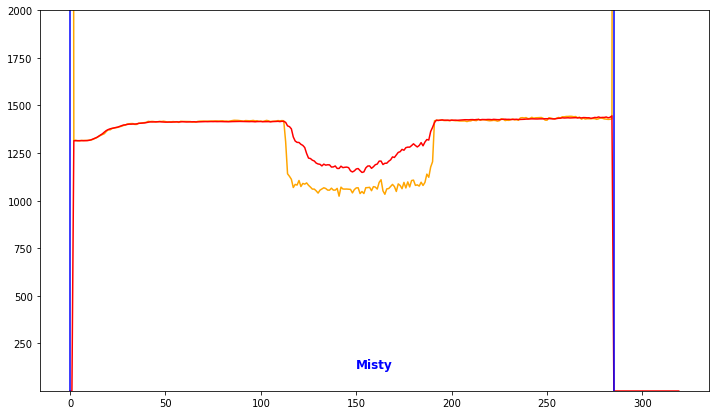

In [107]:
#Calculate the average for the slice
for i in range(320):
    if Slice_cnt[i] > 0:
        sumSliceDistance[i] = Slice_sum[i]/Slice_cnt[i]

#Calculate the average for each column over the ENTIRE depth picture
for i in range(320):
    if colDepthCount[i] !=0:
        columnDepth[i] = colDepthSum[i]/colDepthCount[i]
        
#Plot both the average and slice arrays
fig = plt.figure()
ax = plt.subplot(111)

plt.plot(sumSliceDistance, 'orange')
plt.plot(columnDepth, 'r')
ax.set_ylim(1,2000);

#two vertical lines at 0 and 320 - the limits of the sensor 
plt.plot([0, 0], [0, 2100], 'b');
#plt.plot([320, 320], [0, 2100], 'b'); #320 is the max - but the sensor does not appear to go over that far
plt.plot([285, 285], [0, 2100], 'b'); #285 is where the sensor appears to stop

#place "Misty" where is placed and looking from  
plt.annotate('Misty', xy=(150, 120), c='b', fontsize = 'large', fontweight = 'bold');
#Change the axis to not show the 10000 out of the way points. 

The Green line shows where the depth data is constrained to for sumSliceDistance. All columns in this range are averaged.


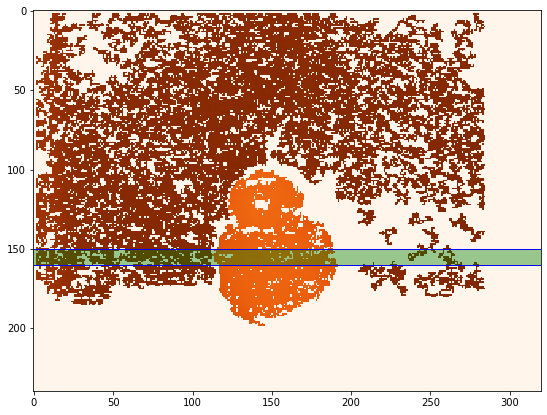

In [109]:
# Re-plot the entire DepthPicture (with points) and inlay lines 
# that show the positions of consolidated points, and the depth 
# level of each of the 12 points

plt.rcParams['figure.figsize'] = [12, 7]
plt.imshow(data, cmap=plt.get_cmap('Oranges')); #Oranges instead of Greys for BB8 - plus it makes blue lines show up better 

c_width = botline-topline;
c_aveline = (botline+topline)/2;

#plot horizontal lines
plt.plot([0, 319], [botline, botline], 'b', linewidth='1'); # plot([x1,x2], [y1,y2], color='b')
plt.plot([0, 319], [topline, topline], 'b', linewidth='1');
plt.plot([0, 319], [c_aveline, c_aveline], 'g-', alpha=0.4, linewidth=c_width*1.5); #plot average thick line

print("The Green line shows where the depth data is constrained to for sumSliceDistance. Columns in this range are averaged.")

In [110]:
#Print out the array to see it
sumSliceDistance

array([10000.        , 10000.        ,  1316.791397  ,  1317.287085  ,
        1314.57711419,  1314.00211688,  1316.04034562,  1315.89886793,
        1316.08882121,  1315.9565413 ,  1317.46511556,  1318.95094559,
        1321.74398   ,  1326.32651937,  1330.92850857,  1336.6634848 ,
        1342.6612496 ,  1347.10288097,  1351.73148742,  1363.19175923,
        1372.11255353,  1371.74790906,  1378.97465839,  1381.24877   ,
        1383.33429129,  1384.81336139,  1388.17377086,  1390.64913179,
        1394.65142966,  1397.07189433,  1402.59988519,  1403.92190125,
        1404.81241955,  1404.89812733,  1400.304422  ,  1400.49849211,
        1406.47787629,  1407.08019029,  1408.35373032,  1409.29806207,
        1411.32812364,  1416.57879808,  1415.01070789,  1416.2388325 ,
        1415.26522818,  1412.89036821,  1414.4925475 ,  1416.38801086,
        1415.68459412,  1417.18694657,  1415.320805  ,  1412.36814647,
        1413.408617  ,  1413.745835  ,  1415.30646815,  1414.0363764 ,
      

In [111]:
#Now that have the array - check to see if there is anything within 1meter of Misty, and 
depthThresholdtoWarn = 1000; #Set to 1000mm or 1m

if (min(sumSliceDistance) < depthThresholdtoWarn):
    print("Watch out!")
else:
    print("All Good! Keep Driving")

All Good! Keep Driving
